# Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(188318, 132)

# Data EDA and Transformation

In [4]:
def lossRescale(logloss,ymean,ystd):
    loss = (logloss-ymean)/ystd
    return loss
def lossRestore(logloss, ymean, ystd):
    loss = np.exp(logloss*ystd+ymean)
    return loss

In [5]:
shift=200
colLabel = 'logloss'
colRawLabel = 'loss'
labelColumns = [colLabel, colRawLabel]
data_train_raw[colLabel]=np.log(data_train_raw[colRawLabel]+shift)
print('Skewness of raw loss values: {}'.format(data_train_raw[colRawLabel].skew()))
print('Skewness of log1p loss values: {}'.format(data_train_raw[colLabel].skew()))

Skewness of raw loss values: 3.79495837754
Skewness of log1p loss values: 0.301411340599


In [6]:
ymean=0
ystd=1
# ymean=data_train_raw[colLabel].min()
# ystd=(data_train_raw[colLabel]-ymean).max()
data_train_raw[colLabel]=lossRescale(data_train_raw[colLabel],ymean,ystd)

In [7]:
# # clean outliers in training data
# rescaledMean = data_train_raw[colLabel].mean()
# rescaledStd = data_train_raw[colLabel].std()
# print('Mean of rescaled log1py: {}'.format(rescaledMean))
# print('Std of rescaled log1py: {}'.format(rescaledMean))

# lbound = rescaledMean-3*rescaledStd
# ubound = rescaledMean+3*rescaledStd
# print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
# data_train_raw = data_train_raw[(data_train_raw[colLabel]>=lbound) & (data_train_raw[colLabel]<=ubound)]
# print('Shape of cleaned data: {}'.format(data_train_raw.shape))
# print('Skewness of clipped log1p loss: {}'.format(data_train_raw[colLabel].skew()))

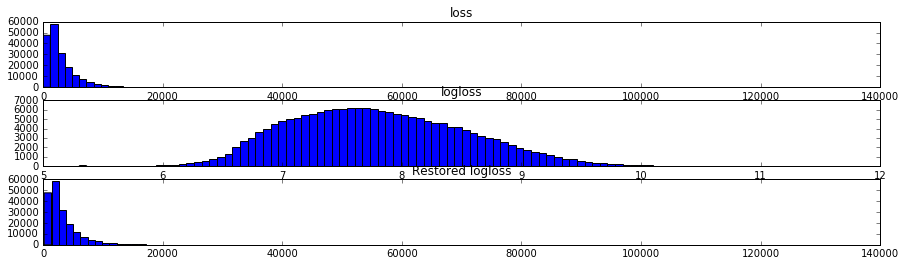

In [8]:
plt.figure(figsize=(15,4))

plt.subplot(3,1,1)
plt.hist(data_train_raw[colRawLabel],100)
plt.title(colRawLabel);
plt.subplot(3,1,2)
plt.hist(data_train_raw[colLabel],100)
plt.title(colLabel);
plt.subplot(3,1,3)
plt.hist(lossRestore(data_train_raw[colLabel],ymean,ystd),100)
plt.title('Restored '+colLabel);

In [9]:
print('Are there any null values?')
print(data_train_raw.isnull().any().any())
print(data_test_raw.isnull().any().any())

Are there any null values?
False
False


In [10]:
print('Logarithmic transformed, rescaled, clipped loss:')
data_train_raw[colLabel].describe()

Logarithmic transformed, rescaled, clipped loss:


count    188318.000000
mean          7.799837
std           0.731553
min           5.301662
25%           7.247408
50%           7.747411
75%           8.309934
max          11.705298
Name: logloss, dtype: float64

# Data preparation - labeling cat features with ordinal information encoded

In [11]:
# save label in a seperate serie
labelSs = data_train_raw[colLabel]
labelColumns.append('id')
trainDf = data_train_raw.drop(labelColumns,axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has {} features from the raw data:\n{}'.format(len(trainDf), trainDf.columns))
print('testDf has {} features from the raw data:\n{}'.format(len(testDf),testDf.columns))

trainDf has 188318 features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has 125546 features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [12]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313864, 130)
(313864, 116) of which are categorical
(313864, 14) of which are continuous


In [13]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [14]:
# LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
# # def LetterRep(x,LevelList):
# #     if x in LevelList:
# #         x = '0'+x
# #     return x
    
# def LetterRep(x,LevelList):
#     if x in LevelList:
#         x = '0'+x
#     return x

# dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
# dataCatAll.head()

In [15]:
features = dataCatAll.columns[0:]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll[feat] = pd.factorize(dataCatAll[feat], sort=True)[0]
dataCatAll.head()
# le.classes_

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0,1,0,1,0,0,0,0,1,0,...,9,6,46,28,2,19,57,0,14,288
1,0,1,0,0,0,0,0,0,1,1,...,10,10,34,67,0,22,39,0,14,94
2,0,1,0,0,1,0,0,0,1,1,...,5,0,2,87,0,28,6,0,8,167
3,1,1,0,1,0,0,0,0,1,0,...,10,10,34,69,2,39,5,0,14,88
4,0,1,0,1,0,0,0,0,1,1,...,6,1,67,51,2,50,39,0,10,63


In [16]:
# # # create additional features using categorical features
# imp_features = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 
#                 'cat13', 'cat14', 'cat16', 'cat17', 'cat18', 'cat19', 'cat23', 'cat24', 'cat25', 'cat28', 'cat29', 
#                 'cat30', 'cat32', 'cat33', 'cat34', 'cat36', 'cat38', 'cat40', 'cat41', 'cat42', 'cat43', 'cat45', 
#                 'cat46', 'cat47', 'cat50', 'cat51', 'cat52', 'cat57', 'cat58', 'cat61', 'cat65', 'cat67', 'cat71', 
#                 'cat72', 'cat73', 'cat75', 'cat76', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat85', 'cat87', 
#                 'cat94', 'cat95', 'cat109']# err cut-off 15000
# rest_features = ['cat15', 'cat18', 'cat20', 'cat21', 'cat22', 'cat26', 'cat27', 'cat31', 'cat34', 'cat35', 'cat37', 'cat44', 
#                  'cat48', 'cat49', 'cat50', 'cat51', 'cat53', 'cat54', 'cat55', 'cat56', 'cat58', 'cat60', 'cat61', 'cat62', 
#                  'cat63', 'cat64', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat74', 'cat77', 'cat84', 'cat86', 'cat88', 
#                  'cat91', 'cat92', 'cat93', 'cat97', 'cat98', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 
#                  'cat106', 'cat107', 'cat108', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat115', 'cat116']

# # # imp_features = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 
# # #                 'cat13', 'cat14', 'cat16', 'cat17', 'cat18', 'cat19', 'cat23', 'cat24', 'cat25', 'cat28', 'cat29', 
# # #                 'cat30', 'cat32', 'cat33', 'cat34', 'cat36', 'cat38', 'cat40', 'cat41', 'cat42', 'cat43', 'cat45', 
# # #                 'cat46', 'cat47', 'cat50', 'cat51', 'cat52', 'cat57', 'cat58', 'cat61', 'cat65', 'cat67', 'cat71', 
# # #                 'cat72']# err cut-off 15000
# # # rest_features = ['cat15', 'cat18', 'cat20', 'cat21', 'cat22', 'cat26', 'cat27', 'cat31', 'cat34', 'cat35', 'cat37', 'cat44', 
# # #                  'cat48', 'cat49', 'cat50', 'cat51', 'cat53', 'cat54', 'cat55', 'cat56', 'cat58', 'cat60', 'cat61', 'cat62', 
# # #                  'cat63', 'cat64', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70']

# dataCatAll['cat117'] = dataCatAll[imp_features].sum(axis=1)
# dataCatAll['cat118'] = dataCatAll[rest_features].sum(axis=1)

# # # # tmpDf = dataCatAll[imp_features]!=0
# # # # dataCatAll['cat117'] = tmpDf.sum(axis=1)

# # # # tmpDf = dataCatAll[rest_features]!=0
# # # # dataCatAll['cat118'] = tmpDf.sum(axis=1)

# # dataCatAll[['cat117','cat118']].head()

In [17]:
# # boxcox transform
# from sklearn.preprocessing import MinMaxScaler
# from scipy.stats import skew, boxcox

# mms = MinMaxScaler()
# print(skew(dataFltAll))
# for col in dataFltAll.columns:
#     if (skew(dataFltAll[col]))>0.25:
#         dataFltAll[col],lam = boxcox(dataFltAll[col]+1)
#         dataFltAll[col] = mms.fit_transform(dataFltAll[col])
# print(skew(dataFltAll))

In [18]:
# dataFltAll.describe()

In [19]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll = mms.fit_transform(dataCatAll)

In [20]:
print(x_catAll.shape)
x_catAll

(313864, 116)


array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.82758621],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.27011494],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.36363636,  0.47988506],
       ..., 
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         0.68181818,  0.89367816],
       [ 0.        ,  0.        ,  0.        , ...,  0.22222222,
         0.63636364,  0.25287356],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.5       ,  0.20114943]])

In [21]:
# len(imp_features)

# one-hot-encoding - skipped in order to keep the alphabetical order

In [22]:
# # one-hot-encoding the categorical features
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# x_catAll = enc.fit_transform(dataCatAll)
# print(x_catAll.shape)

# split x_train and x_test

In [36]:
# split x_train and x_test
x_train = sp.sparse.csc_matrix(sp.sparse.hstack((x_catAll[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:])))
x_test = sp.sparse.csc_matrix(sp.sparse.hstack((x_catAll[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:])))
y_train = labelSs.values

# check the dimension of prepared data

In [37]:
type(x_test.shape)
type(x_train.shape)
type(y_train.shape)

tuple

# split the training data for valication

In [38]:
# from sklearn import cross_validation
# val_size = 0.1
# seed = 0
# x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_train, y_train, test_size=val_size, random_state=seed)
# print(x_train.shape)
# print(y_train.shape)
# print(x_val.shape)
# print(y_val.shape)

In [39]:
# del x_Train
# del y_Train
# del x_catAll
# del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [77]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [78]:
testList = ['XGBoostTrees']

### LightGBM Trees

In [79]:
from pylightgbm.models import GBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold

In [80]:
# params = {  'learning_rate':[0.001,0.01,0.1],
#             'num_leaves': [5,10,20],
#             'tree_learner':['serial'],
#             'num_threads':[8],
#             'min_data_in_leaf':[1,5,10,20],
#             'metric':['l2'],
#             'feature_fraction':[0.5,0.9],
#             'bagging_fraction':[0.5,0.9],
#             'bagging_freq':[0],
#             'metric_freq':[1],
#             'early_stopping_round':[300]
#         }

# gbmr = GBMRegressor(exec_path='/home/ec2-user/LightGBM/lightgbm',config='', application='regression', num_iterations=500,
#                     feature_fraction_seed=seed, bagging_seed=seed, verbose=False)
# clf=GridSearchCV(gbmr, params, scoring='neg_mean_absolute_error', cv=5)
# clf.fit(x_train,y_train)
# clf.best_params_

In [81]:
# clf.best_params_
# {'bagging_fraction': 0.5,
#  'bagging_freq': 0,
#  'early_stopping_round': 300,
#  'feature_fraction': 0.5,
#  'learning_rate': 0.1,
#  'metric': 'l2',
#  'metric_freq': 1,
#  'min_data_in_leaf': 20,
#  'num_leaves': 20,
#  'num_threads': 8,
#  'tree_learner': 'serial'}

In [82]:
n_folds  = 10
kf = KFold(x_train.shape[0], n_folds=n_folds)
pred_y_train = np.zeros((x_train.shape[0],1))
seed = 0
for i, (train_index, test_index) in enumerate(kf):
    print('\n Fold %d' % (i + 1))
    x_train_k, x_val_k = x_train[train_index,:], x_train[test_index,:]
    print('k th x_train:{}, x_val:{}'.format(x_train_k.shape, x_val_k.shape))
    y_train_k, y_val_k = y_train[train_index], y_train[test_index]    
    print('k th y_train:{}, y_val:{}'.format(y_train_k.shape,y_val_k.shape))
    
#     params = {  'learning_rate':[0.1],
#                 'num_leaves': [10],
#                 'tree_learner':['serial'],
#                 'num_threads':[4],
#                 'min_data_in_leaf':[10],
#                 'metric':['mae'],
#                 'feature_fraction':[1.0],
#                 'bagging_fraction':[1.0],
#                 'bagging_freq':[0],
#                 'metric_freq':[1],
#                 'early_stopping_round':[200]
#             }

#     gbmr = GBMRegressor(exec_path='/home/ec2-user/LightGBM/lightgbm',config='', application='regression', num_iterations=500,
#                         feature_fraction_seed=seed, bagging_seed=seed,verbose=False)
    gbmr = GBMRegressor(exec_path='/home/ec2-user/LightGBM/lightgbm',config='', application='regression', num_iterations=1300,
                        feature_fraction_seed=seed, bagging_seed=seed, learning_rate=0.01,num_leaves=200,
                        min_data_in_leaf=20, feature_fraction=0.3, bagging_fraction=0.8,verbose=False)
    gbmr.fit(x_train_k,y_train_k)
    pred_y_train[test_index,0] = gbmr.predict(x_val_k)

    print(mean_absolute_error(lossRestore(y_val_k,ymean,ystd)-shift,lossRestore(gbmr.predict(x_val_k),ymean,ystd)-shift))
#     pred_val = lossRestore(gbmr.predict(x_val_k),ymean,ystd)-shift
#     y_pred_val.append(pred_val)
    
    pred_k = lossRestore(gbmr.predict(x_test),ymean,ystd)-shift
    y_pred.append(pred_k)


 Fold 1
k th x_train:(169486, 130), x_val:(18832, 130)
k th y_train:(169486,), y_val:(18832,)
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
1143.00549692

 Fold 2
k th x_train:(169486, 130), x_val:(18832, 130)
k th y_train:(169486,), y_val:(18832,)
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
1127.19651515

 Fold 3
k th x_train:(169486, 130), x_val:(18832, 130)
k th y_train:(169486,), y_val:(18832,)
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
1139.08977742

 Fold 4
k th x_train:(169486, 130), x_val:(18832, 130)
k th y_train:(169486,), y_val:(18832,)
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
1121.2

In [83]:
# average bagging results
prediction = (np.ndarray.mean(np.vstack(y_pred).T,axis=1))
# prediction_val = (np.ndarray.mean(np.vstack(y_pred_val).T,axis=1))
# ensembled y_val
# print('The loss of the bagged result:')
# mean_absolute_error(lossRestore(y_val,ymean,ystd),prediction_val)

In [86]:
from sklearn.externals import joblib
joblib.dump(pred_y_train, '../output/lgbm_10folds_pred_on_train.sav') 

['../output/lgbm_10folds_pred_on_train.sav']

# save files for submission

In [87]:
# Save all the predictions for submission
submission['id'] = subId
submission['loss']=pd.Series(data=prediction)
submission.to_csv('../output/lgbm_10folds.csv',index=False)

In [ ]:
# from sklearn.externals import joblib
# joblib.dump([gbt, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_test, shift]
#             ,'../output/models-raw-features-rescale-loss-shift.pkl',compress=3) 

# # clf = joblib.load('filename.pkl') 

In [ ]:
testList
